# В данном ноутбуке я попробовал реализовать свою идею по рекомендациям с использованием жанров фильмов. 

Реализация представлена после этого блока кода.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random

from sklearn.metrics.pairwise import cosine_similarity

In [2]:
ratings = pd.read_csv("rating.csv")
ratings = ratings.sort_values(['timestamp'])

In [3]:
ratings

,userId,movieId,rating,timestamp
4182421,28507,1176,4.0,1995-01-09 11:46:44
18950979,131160,1079,3.0,1995-01-09 11:46:49
18950936,131160,47,5.0,1995-01-09 11:46:49
18950930,131160,21,3.0,1995-01-09 11:46:49
12341178,85252,45,3.0,1996-01-29 00:00:00
...,...,...,...,...
7819902,53930,118706,3.5,2015-03-31 06:00:51
2508834,16978,2093,3.5,2015-03-31 06:03:17
12898546,89081,55232,3.5,2015-03-31 06:11:26
12898527,89081,52458,4.0,2015-03-31 06:11:28


In [4]:
print(ratings['userId'].unique().size)
print(ratings['movieId'].unique().size)

138493
26744


In [5]:
train, test = ratings[:8000], ratings[8000:10000]

# Metrics

In [6]:
def average_precision(actual, recommended, k=10):
    ap_sum = 0
    hits = 0
    for i in range(k):
        product_id = recommended[i] if i < len(recommended) else None
        if product_id is not None and product_id in actual:
            hits += 1
            ap_sum += hits / (i + 1)
    return ap_sum / k


def normalized_average_precision(actual, recommended, k=10):
    actual = set(actual)
    if len(actual) == 0:
        return 0.0

    ap = average_precision(actual, recommended, k=k)
    ap_ideal = average_precision(actual, list(actual)[:k], k=k)
    return ap / ap_ideal

Выбрал **NAP**, так как данная метрика неплохо подходит для данной задачи и она очень популярна в задачах RecSys. Во многих крутых статьях её советуют, так почему бы её не попробовать. :) 

# Non-personalized recommendations

In [7]:
user_ratings = sorted(ratings['rating'].unique())
user_ratings

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

In [8]:
user_ratings_with_coef = (
    (0.5, -3), 
    (1.0, -1),
    (1.5, -1),
    (2.0, -0.5), 
    (2.5, -0.5),
    
    (3.0, 3),
    (3.5, 4),
    
    (4.0, 6),
    (4.5, 7),
    (5.0, 8),
)

In [9]:
def weight(item, user_ratings_with_coef):    
    sum = 0
    for rate, coef in user_ratings_with_coef:
        cnt = train[(train['movieId'] == item) & (train['rating'] == rate)]['userId'].count()
        sum += coef * cnt
    return sum

In [10]:
dct = {
    'item' : [],
    'weight' : []
}
for item in tqdm(train['movieId'].unique()):
    dct['item'].append(item)
    dct['weight'].append(weight(item, user_ratings_with_coef))

best_item = pd.DataFrame(dct)

100%|███████████████████████████████████████████████████████████████████████████████| 490/490 [00:04<00:00, 111.33it/s]


In [11]:
best_item.sort_values(by=['weight'], ascending=False, inplace=True)

In [12]:
best_item.head()

,item,weight
299,150,883.5
105,296,794.5
222,318,624.0
173,300,580.5
316,153,569.0


In [13]:
def non_personalized_recommend(user, k=10):    
    best_items = best_item['item'].values
    
    if user in train['userId']:
        old = train[train['userId'] == user]['movieId'].unique()
        indices = np.in1d(best_items, old, invert=True)
        return best_items[indices][:k]
    else:
        return best_items[:k]

In [14]:
scores = []
for user in tqdm(test['userId'].unique()):
    actual = list(test[test['userId'] == user]['movieId'])
    recommended = non_personalized_recommend(user)
    
    scores.append(normalized_average_precision(actual, recommended))

print(np.mean(scores))
print(np.mean(scores) > 0.3)

100%|████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 1070.39it/s]

0.36890447845804986
True


# Collaborative filtering with cosine similarity

In [15]:
train_data = train.copy()

for col in ['userId', 'movieId']:
    train_data[col].replace({val: i for i, val in enumerate(train_data[col].unique())}, inplace=True)

In [16]:
train_data.head()

,userId,movieId,rating,timestamp
4182421,0,0,4.0,1995-01-09 11:46:44
18950979,1,1,3.0,1995-01-09 11:46:49
18950936,1,2,5.0,1995-01-09 11:46:49
18950930,1,3,3.0,1995-01-09 11:46:49
12341178,2,4,3.0,1996-01-29 00:00:00


In [17]:
n_users = train.userId.unique().shape[0]
n_items = train.movieId.unique().shape[0]

ratings_mat = np.zeros((n_users, n_items))
for line in tqdm(train_data.itertuples()):
    ratings_mat[line[1], line[2]] = line[3]

8000it [00:00, 501396.13it/s]


In [18]:
ratings_mat

array([[4., 0., 0., ..., 0., 0., 0.],
       [0., 3., 5., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 5., ..., 0., 0., 5.],
       [0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
%%time
user_similarity = cosine_similarity(ratings_mat)
item_similarity = cosine_similarity(ratings_mat.T)

Wall time: 17.8 ms


In [20]:
user_similarity[:5, :5]

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.08866296, 0.        , 0.08185242],
       [0.        , 0.08866296, 1.        , 0.13807723, 0.16469988],
       [0.        , 0.        , 0.13807723, 1.        , 0.0637355 ],
       [0.        , 0.08185242, 0.16469988, 0.0637355 , 1.        ]])

In [21]:
item_similarity[:5, :5]

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.15764167, 0.08796935, 0.        ],
       [0.        , 0.15764167, 1.        , 0.29491838, 0.23922842],
       [0.        , 0.08796935, 0.29491838, 1.        , 0.3913978 ],
       [0.        , 0.        , 0.23922842, 0.3913978 , 1.        ]])

In [22]:
def predict(ratings_mat, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings_mat) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings_mat.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [23]:
user_data_for_predict = {}
pred = predict(ratings_mat, user_similarity, kind='user')

for user in tqdm(train['userId'].unique()):
    user_ind = np.where(train['userId'].unique() == user)[0][0]
    
    tup_predict = []
    for i in range(len(pred[user_ind, :])):
        tup_predict.append((pred[user_ind, :][i],
                            train['movieId'].unique()[i]))
    user_data_for_predict[user] = tup_predict

100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:13<00:00, 15.99it/s]


### User-based

In [24]:
def recommend_user_based(user, k=10): 
    if user in train['userId'].unique():
        tup_predict = data_for_predict[user]   
            
        old = train[train['userId'] == user]['movieId'].values
        tup_predict.sort(reverse=True)
        return [i[1] for i in tup_predict if i[1] not in old][:k]
    else:
        return non_personalized_recommend(user)

In [47]:
scores = []
for user in tqdm(test['userId'].unique()):
    actual = list(test[test['userId'] == user]['movieId'])
    recommended = recommend_user_based(user)
    
    scores.append(normalized_average_precision(actual, recommended))

np.mean(scores)

100%|█████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 715.67it/s]


0.3728840702947846

### Item-based

In [25]:
item_data_for_predict = {}
pred = predict(ratings_mat, item_similarity, kind='item')

for user in tqdm(train['userId'].unique()):
    user_ind = np.where(train['userId'].unique() == user)[0][0]
    
    tup_predict = []
    for i in range(len(pred[user_ind, :])):
        tup_predict.append((pred[user_ind, :][i],
                            train['movieId'].unique()[i]))
    item_data_for_predict[user] = tup_predict

100%|████████████████████████████████████████████████████████████████████████████████| 217/217 [00:13<00:00, 16.06it/s]


In [26]:
def recommend_item_based(user, k=10): 
    if user in train['userId'].unique():
        tup_predict = data_for_predict[user]   
            
        old = train[train['userId'] == user]['movieId'].values
        tup_predict.sort(reverse=True)
        return [i[1] for i in tup_predict if i[1] not in old][:k]
    else:
        return non_personalized_recommend(user)

In [52]:
scores = []
for user in tqdm(test['userId'].unique()):
    actual = list(test[test['userId'] == user]['movieId'])
    recommended = recommend_item_based(user)
    
    scores.append(normalized_average_precision(actual, recommended))

np.mean(scores)

100%|█████████████████████████████████████████████████████████████████████████████████| 56/56 [00:00<00:00, 369.12it/s]


0.37819019274376414

In [27]:
train['userId'].unique()

array([ 28507, 131160,  85252,  20821, 134445,  99851,  53434, 108467,
       124035,  46380, 113947, 121731,  25197,  48844,   8050,  56139,
        91454,  92320, 130558,  99961,  22528, 107537,  63203, 112497,
        81468,  63308,   4864,  97606,  68648,  21948,  31699,  84082,
       136443,  80229,  55252, 100873,  64402,  76615,  73761,  77014,
       135241,  40055,  20990, 125062, 137727,   7546,  94179,   7334,
        13261,  75907,  53112,  68844, 135464,  66360,  11825,  50725,
        99835,   3338, 127988,  25080,  95139, 131208,   3654,  60738,
         1540,  38173,  46767,  32171,   9552,  77549,  88159, 121607,
        28062,    751, 100365,  59498,  90728, 137835,  12987,  84888,
       107394, 137050,   2729, 115234, 101181, 127583,   3169, 123816,
       108902,  92659,  24474, 112969,  19281,  76009,   2229, 133722,
        30556,  14313, 125758,  86732,  91865, 122784, 129129, 129390,
        47981,  68999,  60595,  35791,  53788, 130661, 135270,  55716,
      

In [32]:
sorted(item_data_for_predict[135270], reverse=True)

[(4.535066201053263, 701),
 (4.535066201053263, 625),
 (4.535066201053263, 80),
 (1.4078653190866326, 149),
 (1.28770089484999, 242),
 (1.0140226709499356, 341),
 (0.9804356194799146, 621),
 (0.8636066482797965, 37),
 (0.8255730054196403, 213),
 (0.7915287079258273, 233),
 (0.7892221680117314, 278),
 (0.730359899741779, 687),
 (0.730359899741779, 495),
 (0.6950288285358139, 224),
 (0.6843061877119713, 698),
 (0.6689676773912431, 105),
 (0.6652243550556504, 272),
 (0.6648746134060396, 335),
 (0.6489786558538633, 695),
 (0.6261720058187669, 314),
 (0.625182266526224, 215),
 (0.61764130961075, 254),
 (0.6164089335564767, 306),
 (0.6153547032724526, 468),
 (0.5948383983472513, 321),
 (0.5940519571570282, 144),
 (0.5934218807785487, 666),
 (0.5807416813153851, 282),
 (0.5596088032518262, 17),
 (0.5586440006483937, 271),
 (0.5530208158015646, 265),
 (0.5474094463320658, 638),
 (0.5435929274887709, 299),
 (0.5420704118404798, 162),
 (0.5328338603506696, 301),
 (0.5325026539535868, 82),
 (0.52

# Посмотрим на другие данные

In [28]:
import pandas as pd
pd.set_option('display.max_columns', 30)

import numpy as np

Просмотрев все датасеты, появилась следующая идея, которая будет использовать не только рейтинги, выставленные пользователями, но и информацию и фильмах.

## Идея:

На вход нам подают пользователя. Мы отбираем из просмотренных им фильмов те, которые ему понравились больше всего (например, у которых оценка выше 4.5).

Далее, берем эти фильмы, и получаем вектора их жанров (в виде эмбеддинга, как one-hot-encoding). Данные эмбеддинги будем использовать для кластеризации. Будем искать ближайших соседей этих фильмов и предлагать те, которые он не смотрел.

Чтобы быстро кластеризовать, будем исопльзовать алгоритм агломеративной иерархической кластеризации, который реализован в библиотеке hnswlib.

In [29]:
ratings = pd.read_csv('rating.csv')
ratings = ratings.sort_values(['timestamp'])

genres = pd.read_csv('movie.csv')

In [31]:
rating_df = ratings[:100000]
rating_df = rating_df.reset_index()

train, test = rating_df[:80000], rating_df[80000:]

# genres_df = genres[genres['movieId'].isin(rating_df['movieId'].unique())]
# genres_df = genres_df.reset_index()

In [32]:
rating_df.shape, genres.shape

((100000, 5), (27278, 3))

In [38]:
rating_df

,index,userId,movieId,rating,timestamp
0,4182421,28507,1176,4.0,1995-01-09 11:46:44
1,18950979,131160,1079,3.0,1995-01-09 11:46:49
2,18950936,131160,47,5.0,1995-01-09 11:46:49
3,18950930,131160,21,3.0,1995-01-09 11:46:49
4,12341178,85252,45,3.0,1996-01-29 00:00:00
...,...,...,...,...,...
99995,178898,1208,193,3.0,1996-05-12 03:38:02
99996,7683970,52904,9,3.0,1996-05-12 03:46:17
99997,18922968,130976,282,3.0,1996-05-12 03:53:16
99998,18922932,130976,168,3.0,1996-05-12 03:54:20


In [39]:
genres

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [42]:
genres['movieId'].unique().shape

(27278,)

### Преобразуем жанры в эмбеддинги

In [8]:
expand_genres = genres_df["genres"].str.split("|", expand=True)
expand_genres

,0,1,2,3,4,5
0,Adventure,Animation,Children,Comedy,Fantasy,None
1,Adventure,Children,Fantasy,None,None,None
2,Comedy,Romance,None,None,None,None
3,Comedy,Drama,Romance,None,None,None
4,Comedy,None,None,None,None,None
...,...,...,...,...,...,...
638,Documentary,None,None,None,None,None
639,Comedy,Crime,None,None,None,None
640,Drama,Fantasy,Romance,None,None,None
641,Comedy,None,None,None,None,None


In [12]:
new_genres = pd.concat([expand_genres, genres_df], axis=1)
new_genres

,0,1,2,3,4,5,index,movieId,title,genres
0,Adventure,Animation,Children,Comedy,Fantasy,None,0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,Adventure,Children,Fantasy,None,None,None,1,2,Jumanji (1995),Adventure|Children|Fantasy
2,Comedy,Romance,None,None,None,None,2,3,Grumpier Old Men (1995),Comedy|Romance
3,Comedy,Drama,Romance,None,None,None,3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,Comedy,None,None,None,None,None,4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...,...,...,...,...,...,...,...
638,Documentary,None,None,None,None,None,774,787,"Gate of Heavenly Peace, The (1995)",Documentary
639,Comedy,Crime,None,None,None,None,1057,1079,"Fish Called Wanda, A (1988)",Comedy|Crime
640,Drama,Fantasy,Romance,None,None,None,1153,1176,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance
641,Comedy,None,None,None,None,None,2508,2593,"Monster, The (Mostro, Il) (1994)",Comedy


In [13]:
tmp1 = pd.melt(new_genres, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5])

In [15]:
tmp1[tmp1['movieId'] == 1]

,movieId,variable,value
0,1,0,Adventure
643,1,1,Animation
1286,1,2,Children
1929,1,3,Comedy
2572,1,4,Fantasy
3215,1,5,None


In [17]:
tmp2 = pd.get_dummies(tmp1.value)

In [20]:
tmp3 = pd.concat([tmp1, tmp2], axis=1)

In [21]:
tmp3

,movieId,variable,value,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,Adventure,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,Adventure,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,Comedy,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3853,787,5,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3854,1079,5,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3855,1176,5,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3856,2593,5,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
tmp3[tmp3['movieId'] == 1]

,movieId,variable,value,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,Adventure,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
643,1,1,Animation,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1286,1,2,Children,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1929,1,3,Comedy,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2572,1,4,Fantasy,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3215,1,5,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
tmp3[(tmp3['movieId'] == 1) & (tmp3['Adventure'] == 1)]

,movieId,variable,value,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,Adventure,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Структурируем все методы и функции

In [79]:
import pandas as pd
import numpy as np

import hnswlib


class Preprocessor:
    def __init__(self, rating_df, genre_df):
        self.rating_df = rating_df
        self.genre_df = genre_df

        self.ohe_genres = None
        self._generate_ohe_genres()

    def _generate_ohe_genres(self):
        split_genres = self.genre_df["genres"].str.split("|", expand=True)
        expand_genres = pd.concat([self.genre_df, split_genres], axis=1)

        genre_melt = pd.melt(expand_genres, id_vars='movieId', value_vars=np.arange(split_genres.shape[1]))

        result_df = pd.concat([genre_melt[['movieId']], pd.get_dummies(genre_melt.value)], axis=1)
        result_df = result_df.reset_index(drop=True)

        self.ohe_genres = result_df

    def _get_favorite_movies(self, user, threshold=4.0):
        return self.rating_df[(self.rating_df['userId'] == user) & (self.rating_df['rating'] > threshold)]

    def _get_embedding(self, movie):
        columns = list(self.ohe_genres.columns)
        columns.remove('movieId')

        embedding = np.zeros(len(columns))
        for i, col in enumerate(columns):
            movie_genre = self.ohe_genres[(self.ohe_genres['movieId'] == movie) & (self.ohe_genres[col] == 1)]
            embedding[i] = 1 if movie_genre.shape[0] > 0 else 0

        return embedding

    def _generate_embeddings(self, movies):
        data = []
        for movie in movies:
            data.append(self._get_embedding(movie))

        return data

    def generate_data_for_user(self, user):
        if user not in self.rating_df['userId'].unique():
            return None, None

        favorite_movies = self._get_favorite_movies(user)
        movies = favorite_movies['movieId'].unique()

        data = self._generate_embeddings(movies)
        return data, movies

    def generate_all_embeddings_labels(self):
        movies = self.rating_df['movieId'].unique()
        return self._generate_embeddings(movies), movies


class ANNRecommendationSystem:
    def __init__(self, ef_construction=200, M=32, space='l2', k=10):
        self.ef_construction = ef_construction
        self.M = M
        self.space = space
        self.k = k

        self.p = None

    def fit(self, data, ids):
        data = np.array(data)
        ids = np.array(ids)
        
        max_elements = data.shape[0]
        dim = data.shape[1]

        self.p = hnswlib.Index(space=self.space, dim=dim)
        self.p.init_index(max_elements=max_elements, ef_construction=self.ef_construction, M=self.M)

        self.p.add_items(data, ids)

        return self

    def predict(self, movies_embedding, ids):
        labels, _ = self.p.knn_query(movies_embedding, k=self.k)
        labels = np.array(labels)
        labels.reshape((1, -1))

        result = [i for i in labels[0] if i not in ids]
        return result

In [34]:
preprocessor = Preprocessor(train, genres)

In [35]:
preprocessor.ohe_genres

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272775,131254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
272776,131256,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
272777,131258,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
272778,131260,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
data, labels = preprocessor.generate_all_embeddings_labels()

In [52]:
recsys = ANNRecommendationSystem()

In [53]:
recsys.fit(data, labels)

In [54]:
test

,index,userId,movieId,rating,timestamp
80000,7612360,52458,22,5.0,1996-05-09 02:09:03
80001,7612366,52458,170,3.0,1996-05-09 02:09:59
80002,10907022,75440,150,3.0,1996-05-09 02:10:34
80003,10907082,75440,590,4.0,1996-05-09 02:10:34
80004,10907083,75440,592,3.0,1996-05-09 02:10:34
...,...,...,...,...,...
99995,178898,1208,193,3.0,1996-05-12 03:38:02
99996,7683970,52904,9,3.0,1996-05-12 03:46:17
99997,18922968,130976,282,3.0,1996-05-12 03:53:16
99998,18922932,130976,168,3.0,1996-05-12 03:54:20


In [59]:
user = 52458

In [60]:
emb, lab = preprocessor.generate_data_for_user(user)

In [61]:
recsys.predict(emb, lab)

[608, 20, 21, 45, 109, 111, 319, 463, 507]

### Померим результат на метрике:

In [74]:
def recom_by_clusterization(user, k=10):
    non_perconalized_precict = non_personalized_recommend(user, k)
    
    emb, lab = preprocessor.generate_data_for_user(user)
    if not emb:
        return non_perconalized_precict
    
    prediction = recsys.predict(emb, lab)
    
    i = 0
    while i < k and len(prediction) < k:
        if non_perconalized_precict[i] not in prediction:
            prediction.append(non_perconalized_precict[i])
        
        i += 1
    
    return prediction

In [75]:
scores = []
for user in tqdm(test['userId'].unique()):
#     print(user)
    
    actual = list(test[test['userId'] == user]['movieId'])
    recommended = recom_by_clusterization(user)
    
    scores.append(normalized_average_precision(actual, recommended))

np.mean(scores)

100%|████████████████████████████████████████████████████████████████████████████████| 408/408 [00:17<00:00, 23.91it/s]


0.5229600451291628

Получился неплохой результат! 

К тому же, он гораздо быстрее, чем коллаборативная фильтрация.

### Подмешаем этот подход с коллаборативной фильтрацией

Будем сортировать выход модели кластеризации

In [109]:
rating_df = ratings[:120000]
rating_df = rating_df.reset_index()

train, test = rating_df[:100000], rating_df[100000:]

# genres_df = genres[genres['movieId'].isin(rating_df['movieId'].unique())]
# genres_df = genres_df.reset_index()

In [110]:
preprocessor = Preprocessor(train, genres)
recsys = ANNRecommendationSystem()

data, labels = preprocessor.generate_all_embeddings_labels()
recsys.fit(data, labels)

In [111]:
# def smart_sorting(user, item_data_for_predict, pred_labels):
#     """Sort predict from clusterization using item-based output."""
    
#     pred_ratings = item_data_for_predict[user]
#     pred_ratings.sort(reverse=True)
#     pred_ratings = np.array(pred_ratings)
    
#     labels = pred_ratings[:, 1]
#     return [i for i in labels if i in pred_labels]

In [117]:
def smart_sorting2(user, best_items, pred_labels):
    """Sort predict from clusterization using item-based output."""

    labels = best_items['item'].values
    return [i for i in labels if i in pred_labels]

In [118]:
def recom_by_collab_cluster(user, k=10):
    non_perconalized_precict = non_personalized_recommend(user, k)
    
    emb, lab = preprocessor.generate_data_for_user(user)
    if not emb:
        return non_perconalized_precict
    
    prediction = recsys.predict(emb, lab)
    prediction = smart_sorting2(user, best_item, prediction)
    
    i = 0
    while i < k and len(prediction) < k:
        if non_perconalized_precict[i] not in prediction:
            prediction.append(non_perconalized_precict[i])
        
        i += 1
    
    return prediction

In [119]:
scores = []
for user in tqdm(test['userId'].unique()):
#     print(user)
    
    actual = list(test[test['userId'] == user]['movieId'])
    recommended = recom_by_collab_cluster(user)
    
    scores.append(normalized_average_precision(actual, recommended))

np.mean(scores)

100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:20<00:00, 20.74it/s]


0.49409610948118055

## Посмотрим, как зависит наша метрика от k

In [128]:
def score(recom_algo, test, **params):
    scores = []
    for user in tqdm(test['userId'].unique()):
        actual = list(test[test['userId'] == user]['movieId'])
        recommended = recom_algo(user, **params)

        scores.append(normalized_average_precision(actual, recommended))

    return np.mean(scores)

In [129]:
k_s = np.arange(2, 10)
algo = recom_by_collab_cluster

scores = []
for k in k_s:
    scores.append(score(algo, test, k=k))

100%|████████████████████████████████████████████████████████████████████████████████| 422/422 [00:21<00:00, 19.73it/s]


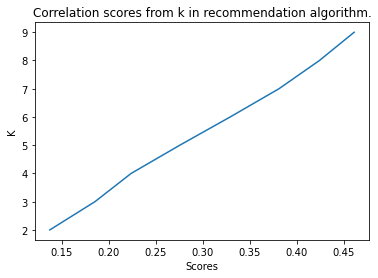

In [130]:
import matplotlib.pyplot as plt

plt.plot(scores, k_s)
plt.xlabel('Scores')
plt.ylabel('K')
plt.title('Correlation scores from k in recommendation algorithm.')
plt.show()